# Exercises Week 10-11: Graded exercise session (part A)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026


In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import gammaln

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell before you submit.**

## Exercise 1: Transcriptional bursting

Let's consider the transcriptional process in which an mRNA $x$ is produced at a rate $s$ and degraded at a rate $k$. We will consider a two-state model for the promoter (Random Telegraph process). This means that the promoter can switch from an active ($g=1$) to inactive state ($g=0$) and vice-versa with respective rates $k_{off}$ and $k_{on}$.


The Telegraph process has the following elementary reactions:  
\begin{array}{lll}
(1, n) \longrightarrow (1, n+1) \textrm{ with rate } s \\
(g, n) \longrightarrow (g, n-1) \textrm{ with rate } k\,n \\
(1, n) \longrightarrow (0, n) \textrm{ with rate } k_{off} \\
(0, n) \longrightarrow (1, n) \textrm{ with rate } k_{on}
\end{array}

We describe the states $(g, n)$ with $g\in \{1, 0\}$, $n \in \mathbb{N}$.

*Hint*: In all of the exercises below, use rates that are plausible biologically, especially for $s$ and $k$ (see course). Note that the units here are in minutes.

#### Question 1
1. Modify/complete the code template provided for the Gillespie algorithm to simulate the Telegraph model.

2. Two genes differ by the percentage of time the promoter is ON (gene1: 100%, gene2 : 10%), but the other parameters are the same ($s$, $k$). Let’s modify gene2 so that it expresses at the same level than gene 1, by either increasing its synthesis rate, or decreasing its degradation rate. Let’s say that you also aim to minimize the variance, which scenario is better? For each of the 4 cases (gene1, gene2, gene2 with synthesis rate up, gene2 with degradation rate down), answer with a simulation and show the distribution of the number of molecules and explain your findings.  
*Note*: For each case, report the variance, the mean level of expression, the expected number of molecules, the coefficient of variation of the number of mRNA copies ($CV=\frac{\sigma}{\mu}$) and the probability of the promoter to be in the $ON$ state.  

#### Gillespie template

In [2]:
def run_gillespie_telegraph(n0, g0, parameters, t_end, DT):
    """
    Simulates the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_on, k_off = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([[ 0,  1],   # production of n
                          [ 0,  -1],   # degradation of n
                          [  -1, 0]])  # Switch to inactive promoter
            rates = np.array([s,    # production rate of n
                              k*n,      # degradation rate of n
                              k_off]) # Switching rate to inactive promoter
        else: # Promoter is inactive
            S = np.array([[ 0,  -1],   # degradation of n
                          [  1,  0]])  # Switch to active promoter
            rates= np.array([k*n,      # Degradation rate of n
                             k_on])  # Switching rate to active promoter
            
        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

In [3]:
def plot_gillespie_telegraph(n, g, t):
    """
    Plots the Random telepgrah process using the Gillespie algorithm.

    Parameters:
    n: Species n counts over time.
    g: Promoter state g over time.
    t: Time points for each recorded reaction.

    """

    fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True)

    # Plotting the number of molecules n over time
    axs[0].plot(t, n, label = 'n(t)', color='darkblue')
    axs[0].set_ylabel('# molecules n')

    # Plotting the promoter activity over time
    axs[1].vlines(x=t, ymin=np.min(g), ymax=np.array(g), colors='teal', lw=2, label='promoter activity')
    axs[1].set_ylim(np.min(g), np.max(g)+0.1)  # Set y-limits to make the promoter states clear (0 and 1)
    axs[1].set_ylabel('Promoter State')
    
    # Common x-label
    plt.xlabel('time [min]')
    
    plt.show()

#### Gene 1

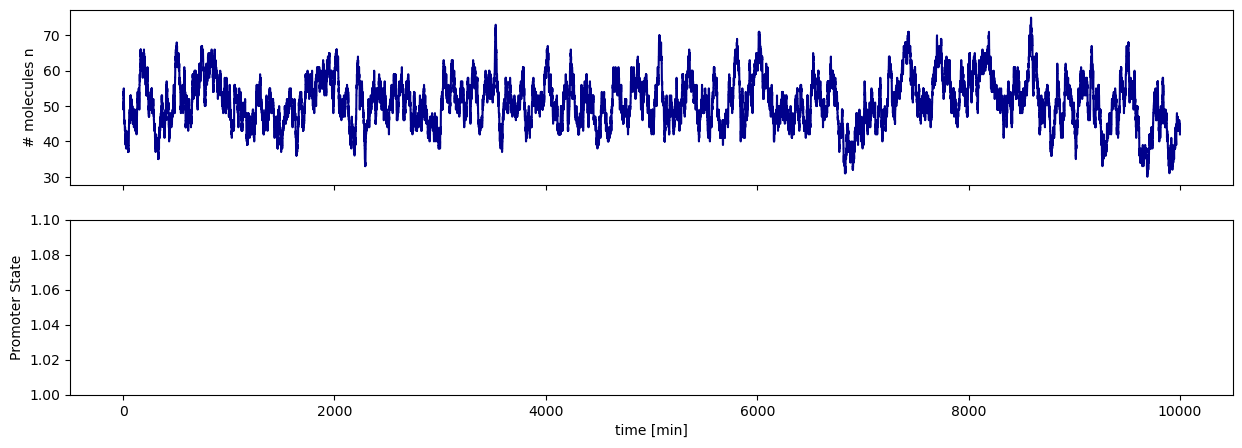

Variance: 46.59185516622318
Mean: 51.14411008770614
Expected Value: 50.0
CV: 0.13346253677135012
Probabiliy Promoter is ON: 1


In [4]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate, 1/k = 50 min
k_off = 0 #Switching off rate, t_on = 1/k_off
k_on  = 1#/120 #Switching on rate, t_off = 1/k_on

p_on = 1

n_0 = s/k * p_on

t_end=10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n_g1, g_g1, t_g1 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n_g1, g_g1, t_g1)

#Compute required stats
var_g1 = np.var(n_g1) 
mean_g1 = np.mean(n_g1)
exp_g1 = p_on*s/k
cv_g1 = np.std(n_g1)/mean_g1

print("Variance:", var_g1)
print("Mean:", mean_g1) 
print("Expected Value:", exp_g1)
print("CV:", cv_g1)
print("Probabiliy Promoter is ON:", p_on)

#### Gene 2

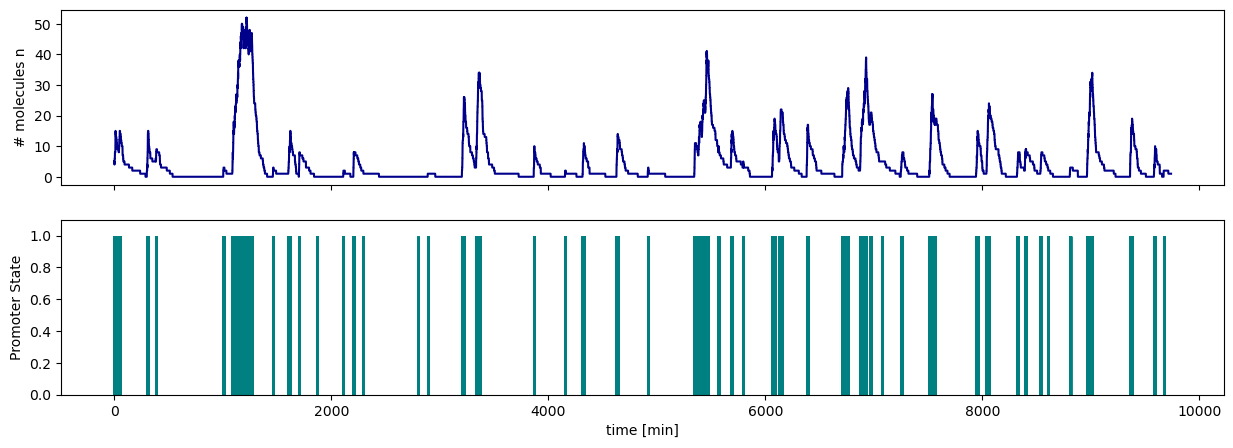

Variance: 62.11262954042804
Mean: 4.465432441035436
Expected Value: 5.0
CV: 1.7649257302429426
Probabiliy Promoter is ON: 0.1


In [5]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off 
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n_g2, g_g2, t_g2 = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n_g2, g_g2, t_g2)

#Compute required stats
var_g2 = np.var(n_g2) 
mean_g2 = np.mean(n_g2)
exp_g2 = p_on*s/k
cv_g2 = np.std(n_g2)/mean_g2

print("Variance:", var_g2)
print("Mean:", mean_g2) 
print("Expected Value:", exp_g2)
print("CV:", cv_g2)
print("Probabiliy Promoter is ON:", p_on)

#### Gene 2 Increased synthesis rate

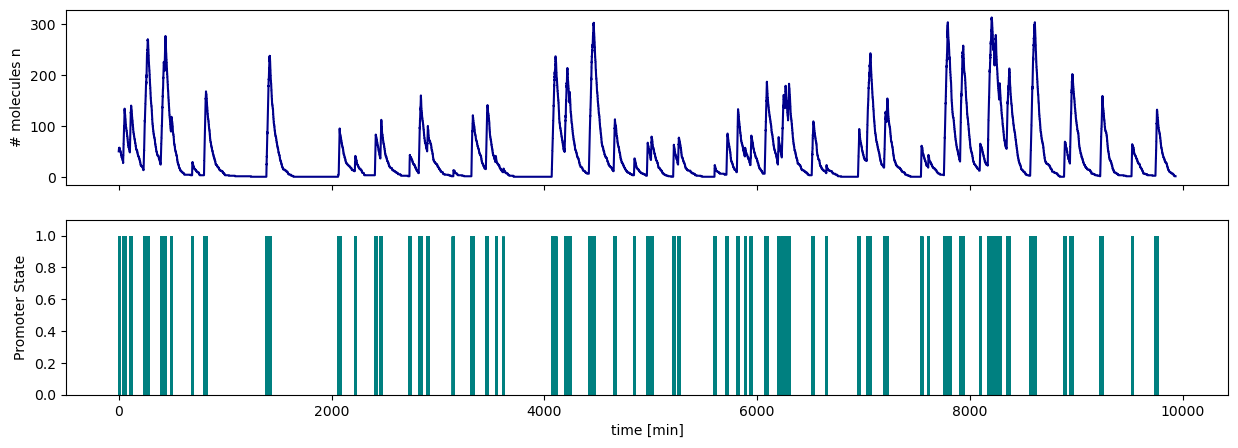

Variance: 3444.1463030495574
Mean: 44.003412969283275
Expected Value: 50.0
CV: 1.3336885829938072
Probabiliy Promoter is ON: 0.1


In [6]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 10 # Number of initiations per minute
k = 0.02 # Degradation rate
k_off = 1/15 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)

n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n_g2_synth, g_g2_synth, t_g2_synth = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n_g2_synth, g_g2_synth, t_g2_synth)

#Compute required stats
var_g2_synth = np.var(n_g2_synth)
mean_g2_synth = np.mean(n_g2_synth)
exp_g2_synth = p_on*s/k
cv_g2_synth = np.std(n_g2_synth)/mean_g2_synth

print("Variance:", var_g2_synth)
print("Mean:", mean_g2_synth) 
print("Expected Value:", exp_g2_synth)
print("CV:", cv_g2_synth)
print("Probabiliy Promoter is ON:", p_on)

#### Gene 2 Reduced degradation rate

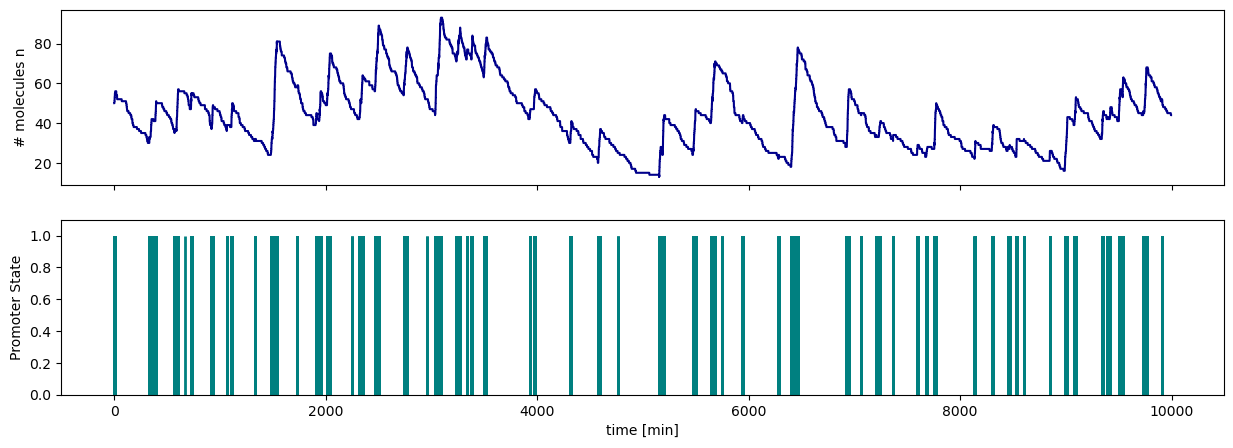

Variance: 271.53931796195224
Mean: 44.073501896080764
Expected Value: 50.0
CV: 0.37388565462434004
Probabiliy Promoter is ON: 0.1


In [7]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state
DT = 0.1 # min
#if needed adjust DT so that it makes sense given the timescales of the system (depending on your rates)

#Parameters, these are biologically plausible and should remain so.
s = 1 # Number of initiations per minute
k = 0.002 # Degradation rate
k_off = 1/15 #Switching off rate unit min^-1, t_on = 1/k_off
k_on  = 1/135 #Switching on rate, unit min^-1, t_off = 1/k_on

t_on = 1/k_off
t_off = 1/k_on
p_on = t_on/(t_on+t_off)


n_0=s/k * p_on

t_end = 10000 # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]

n_g2_degr, g_g2_degr, t_g2_degr = run_gillespie_telegraph(n_0, g_0, parameters, t_end, DT)
plot_gillespie_telegraph(n_g2_degr, g_g2_degr, t_g2_degr)

#Compute required stats
var_g2_degr = np.var(n_g2_degr)
mean_g2_degr = np.mean(n_g2_degr)
exp_g2_degr = p_on*s/k
cv_g2_degr = np.std(n_g2_degr)/mean_g2_degr

print("Variance:", var_g2_degr)
print("Mean:", mean_g2_degr) 
print("Expected Value:", exp_g2_degr)
print("CV:", cv_g2_degr)
print("Probabiliy Promoter is ON:", p_on)

#### Answer ####

In [9]:
from IPython.display import Markdown

table = f"""
| Gene | Mean | Variance |
|------|------|----------|
| 1 | {mean_g1:.2f} | {var_g1:.2f} |
| 2 | {mean_g2:.2f} | {var_g2:.2f} |
| 2 (increased synthesis) | {mean_g2_synth:.2f} | {var_g2_synth:.2f} |
| 2 (decreased degradation) | {mean_g2_degr:.2f} | {var_g2_degr:.2f} |
"""


- **Gene 1**: The transcription of gene 1 is always on, so the promoter does not switch between the on and off states. There is no transcriptional bursting in this case, and the gene expression follows a birth-death process. The aim is thus to match this level of expression of about 50 molecules. 

- **Gene 2**: For gene 2, the promoter is only on 10% of the tine, which 
is 10 times lower than for gene 1. Since the expected number of mRNA molecules is calculated with 
$E[n] = p_{on} \times s/k$ and $E[n]$ is proportional to $p_{on}$, it follows that the amount of expected mRNA molecules is also 10 times lower than that of gene 1.

- **Gene 2 (increased synthesis)**: In this first scenario, to compensate the low $p_{on}$, we increase the synthesis rate 10 fold. Since the expression rate is directly proportional to s ($E[n] = p_{on} \times s/k$), this compensates and brings the mean closer to that of gene 1. We note on the corresponding graph, that transcription happens less often, but in more intense bursts: the peaks in gene 1 do not go higher than n=70, whereas in this case, the peaks can reach upto n = 400. Because of these large bursts, there is higher variance in this scenario.

- **Gene 2 (decreased degradation)**: In this second scenario, in order to match the expression rate of gene 1, we decrease the degradation rate 10 fold. Since the expression rate is inversely proportional to k ($E[n] = p_{on} \times s/k$), this increases the expected number of molecules by increasing the half-lives of the mRNA molecules. As seen on the plot, molecules decay slower and thus somewhat average out the fluctuation caused by the the switching between on and off states of the promoter. This leads to smoother variations and less varuance. 

The scenario which leads to the lowest variance is the second scenario, where the degradation rate is decreased. 

#### Question 2
1. Identify parameters that results in a Poisson distribution of mRNA numbers. Explain why these parameters produce a Poisson distribution. Show the empiral histogram and overlay an exact Poisson distribution. In this regime, explain how the parameters of the Telegraph model relate to the parameter of the Poisson distribution. *Hint*: $k_{off}=0$ with $g(t=0)=1$ is not the right answer. 

2. Find parameters where the mRNA distribution deviates from the Poisson. *Hint*: Look for a regime that yields a bimodal distribution. Explain your reasoning.  

1) To obtain a poisson distribution we need to use the synthesis and degradation parameters: $\lambda = \frac{s}{k}$ but since we are in a telegraph process we have other parameters. Therefore to approximate the poisson distribution, we need to have $k_{on},k_{off} >> s,k$ because then the promoter switch state fast, and then the system works almost as in birth-death process (as if we didn't have $k_{on},k_{off}$):

    the probability to be in a $ON$ state becomes $Prob_{on}=\frac{k_{on}}{k_{on}+k_{off}}$ 

    and the new s is then: $s_{new}= Prob_{on}*s$

    Then we have 
    $$
    \lambda = \frac{s_{eff}}{k} = \frac{s}{k} \frac{k_{on}}{k_{on} + k_{off}} 
    $$

####  Helper functions for the Poisson distribution

In [8]:
# Poisson distribution
def Poisson(lam, counts):
    """
    Calculate the Poisson distribution probability for given counts.
    
    Parameters:
    lam: The average number of events (rate parameter).
    counts: Observed counts.

    Returns:
    np.array: Probabilities corresponding to the observed counts.

    Notes:
    - This function uses the log-form of the Poisson probability mass function.
    - The gammaln function is used for calculating the logarithm of the factorial term.

    """

    logp = counts * np.log(lam) - lam - gammaln(counts + 1)
    return np.exp(logp)

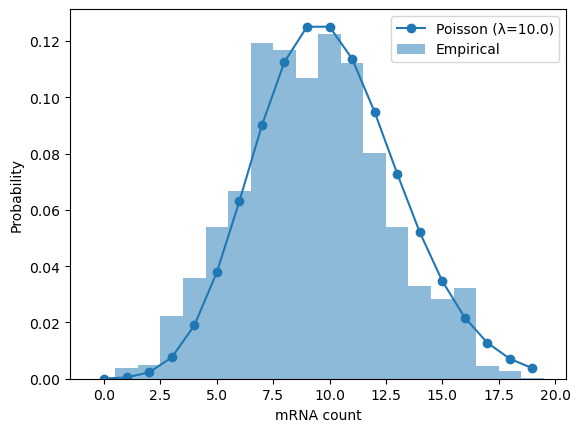

In [15]:
# Parameters for Poisson regime (Fast Switching)
s = 1.0
k = 0.05
# Switching rates must be much faster than k (and s)
k_on = 5.0
k_off = 5.0

t_end = 100 * 1/k # Total simulation time in minutes, adjust if needed
parameters = [s, k, k_on, k_off]

n_p, g_p, t_p = run_gillespie_telegraph(n0=0, g0=1, parameters=parameters,t_end=t_end, DT=0.01)

# We take only the second half of the simulation to ensure steady-state
n_ss = np.array(n_p[len(n_p)//2:])

# Empirical histogram
counts, bin_edges = np.histogram(n_ss, bins=np.arange(0, n_ss.max()+2)-0.5, density=True)
centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Theorical Poisson:
p_on= k_on / (k_on + k_off)
lam = s * p_on / k
pois = Poisson(lam, centers)

plt.bar(centers, counts, width=1.0, alpha=0.5, label='Empirical')
plt.plot(centers, pois, 'o-', label=f'Poisson (λ={lam:.1f})')
plt.xlabel('mRNA count')
plt.ylabel('Probability')
plt.legend()
plt.show()

2)
To have a bimodale distribution, the promoter need to switch state slowly (then we have a switch ON and OFF that affects a lot the synthesis and degradation after during a long time). 

$k_{on},k_{off}<< k$. 

The cell has time to reach a high number of mRNA equilibrium when the gene is ON and a low number of mRNA equilibrium when the gene is OFF: $n_{steady}$ = $\frac{s}{k}$ when gene is ON (high equilibrium)


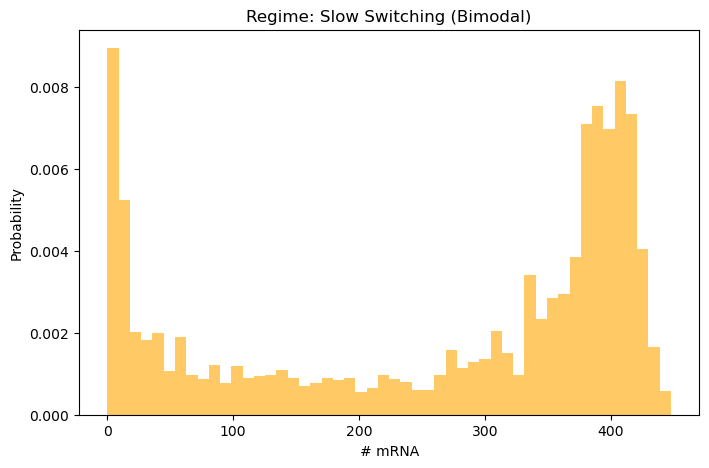

In [24]:
#initial conditions for the state (g,n) at time t=0
g_0 = 1 # Initial promoter state

##Find Parameters giving Poisson distribution
s = 20 # Number of initiations per minute 
k = 0.05 # Degradation rate,  unit min^-1
k_off = 0.01 #Switching off rate, unit min^-1, t_on = 1/k_off
k_on  = 0.01 #Switching on rate, unit min^-1, t_off = 1/k_on

# n_steady = s/k = 400 when ON

n_0=0

DT = 0.01 # min


t_end = 100 * 1/k # Total simulation time in minutes, adjust if needed

parameters = [s, k, k_on, k_off]


n_b, g_b, t_b = run_gillespie_telegraph(n0=0, g0=0, parameters=parameters, t_end=t_end, DT=DT)
n_ss = np.array(n_b[len(n_b)//2:])
plt.figure(figsize=(8,5))
plt.hist(n_ss, bins=50, density=True, color='orange', alpha=0.6)
plt.title("Regime: Slow Switching (Bimodal)")
plt.xlabel("# mRNA")
plt.ylabel("Probability")
plt.show()



#### Question 3 (Promoter cycle)
Transcription in mammals often requires a more complicated telegraph model (promoter cycle), where the promoter state goes through an $ON$ state, and then sequentially goes through several $OFF_n$ state before returning to the ON state. For example with two $OFF$ states, it would look like: $ON\,(g=1)\longrightarrow OFF_1 (g=2) \longrightarrow OFF_2 (g=3) \longrightarrow ON (g=1)$. This is related to the fact that transcription events often show a refractory period, *i.e.* promoter tend to say off for some amount of time before turning back on. 

1. Modify the above code to implement the promoter cycle with two $OFF$ state. First, use rates as in the example above with the following modifications: $s = 20$, $k = 0.02$, $k_{on-off_1} = 1/15$, $k_{off_1-off_2} = 1/60$ and $k_{off_2-on}  = 1/60$. Show some representative simulations. Plot both the mRNA and promoter state and comment.

2.  Study the distribution of the durations of each $OFF$ interval separately and study the distribution of the total duration of the two $OFF$ intervals. Focus on the shape of the distributions. Explain your findings.

3. (Bonus). Can you explain mathematically and biologically the shape of the distribution ? What would happen if you include more $OFF_n$ states?

In [25]:
#Adapt the Gillepsie algorithm to the promoter cycle case
def run_gillespie_refractory(n0, g0, parameters, t_end, DT):
    """
    Simulates the gillepsie algorithm for a gene with a refractory promoter cycle.

    Parameters:
    n0 : Initial count of species n.
    g0 : Initial promoter state g (0 or 1).
    parameters: Tuple containing transcription rate s, degradation rate k, switching rates k_on and k_off
    t_end : Total simulation time.
    DT: time interval for returning/printing the output

    Returns:
    n_print : Trajectory of species n counts over time.
    g_print : Trajectory of promoter state g over time.
    t_print : Time points for each recorded reaction.
    """
    # Initialize state variables and time
    n = n0   
    g = g0   
    t = 0    
    tp = 0  

    # Initialize output lists
    n_print=[]  
    g_print=[]  
    t_print=[]  

    # Unpack parameters
    s, k, k_onoff, k_offoff,koffon = parameters 

    while t < t_end: 
        
        # Define the stoichiometric matrix S (also called state-change matrix) and rate vector for each promoter state
        if g == 1: # Promoter is active 
            S = np.array([[ 0,  1],   # production of n
                          [ 0,  -1],   # degradation of n
                          [ 1, 0]])  # Switch to inactive promoter
            rates = np.array([s,    # Degradation rate of n
                              k*n,      # Production rate of n
                              k_onoff]) # Switching rate to inactive promoter
        elif g==2: # Promoter is inactive
            S = np.array([[ 0,  -1],   # decay of n
                          [  1,  0]])  # Switch to second inactive promoter
            rates= np.array([k*n,      # Degradation rate of n
                             k_offoff])  # Switching rate to second inactive promoter
        elif g==3:
            S = np.array([[ 0,  -1],   # decay of n
                          [  -2, 0]])  # Switch to active promoter (g=1)
            rates= np.array([k*n,      # Degradation rate of n
                             koffon])  # Switching rate to active promoter    
            
        # Calculate total rate and sample time to next reaction
        rates_tot = sum(rates)
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t += dt

        # Determine which reaction occurs next
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1

        # Record output at specified DT intervals (equally spaced output)
        while tp < t and t <= t_end:
            n_print.append(n)
            g_print.append(g)
            t_print.append(tp)
            tp += DT
        
        # Update species n counts and promoter state g
        chosen_react=i
        g += S[chosen_react,0]
        n += S[chosen_react,1]

    return n_print, g_print, t_print

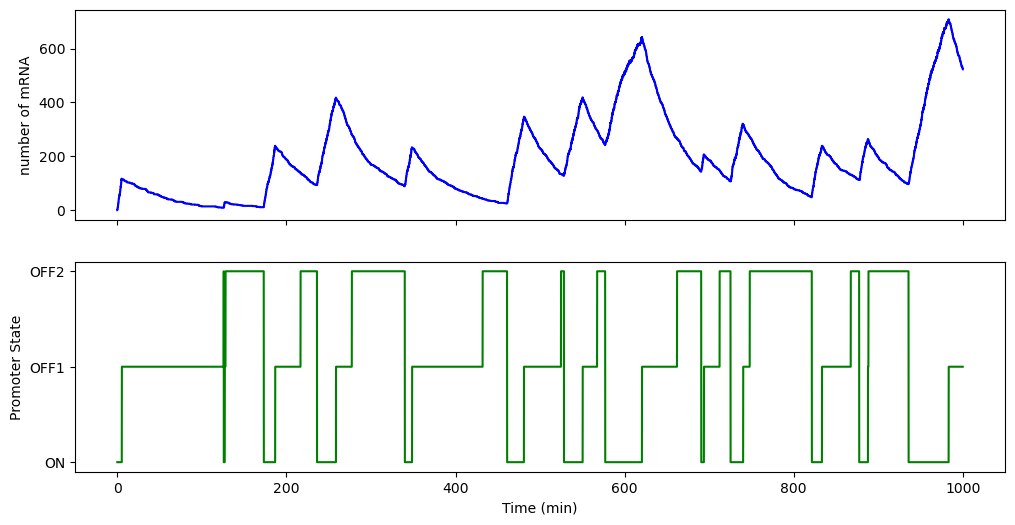

In [37]:
s=20
k=0.02
konoff=1/15
koffoff=1/60
koffon=1/60

t_end = 1000

params= [s, k, konoff, koffoff, koffon]
n_r, g_r, t_r = run_gillespie_refractory(n0=0, g0=1, parameters=params, t_end=t_end, DT=0.01)

# Plots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(t_r, n_r, 'b')
axs[0].set_ylabel("number of mRNA")
axs[1].plot(t_r, g_r, 'g')
axs[1].set_yticks([1, 2, 3])
axs[1].set_yticklabels(['ON', 'OFF1', 'OFF2'])
axs[1].set_ylabel("Promoter State")
axs[1].set_xlabel("Time (min)")
plt.show()

1) We can see that the promoter shows the sequential transition/ intermittent transcription bursts + inactive intervals : $ON -> OFF_{1} -> OFF_{2} -> ON$, the transcription occurs only when we are in the $ON$ state, which causes increases of mRNA number while when we switch to $OFFs$ states no transcription happens and the mRNA number decreases exponentially. Also, we can see that the promoter is more often in $OFF_{2}$ state than in $OFF_{1}$ because $k_{onoff} > k_{offoff}$ therefore it causes a long refractory periods (much slower switch). 

2) We need to look for the total time spent in $OFF$ state (sum and split of $OFF_{1}$ and $OFF_{2}$ states)

In [41]:
s=20
k=0.02
konoff=1/15
koffoff=1/60
koffon=1/60

t_end = 20000

params= [s, k, konoff, koffoff, koffon]
n_r, g_r, t_r = run_gillespie_refractory(n0=0, g0=1, parameters=params, t_end=t_end, DT=0.01)


In [44]:
off1_durations = []
off2_durations = []
off_total_durations = []

i = 0
while i < len(g_r) - 1:
    # We detect the beginning of an OFF block
    if g_r[i] == 1 and g_r[i+1] == 2:
        # start time of OFF total
        t_off_start = t_r[i+1]

        #OFF1 
        j = i+1
        while j < len(g_r) and g_r[j] == 2:
            j += 1
        t_off1_end = t_r[j-1]
        dur1 = t_off1_end - t_off_start
        off1_durations.append(dur1)

        # OFF2
        if j < len(g_r) and g_r[j] == 3:
            k_idx = j
            while k_idx < len(g_r) and g_r[k_idx] == 3:
                k_idx += 1
            t_off2_end = t_r[k_idx-1]
            dur2 = t_off2_end - t_r[j]
            off2_durations.append(dur2)

            # OFF total = OFF1 + OFF2
            off_total_durations.append(dur1 + dur2)

            # we continue after the end of OFF2 (normally we are back to ON)
            i = k_idx
        else:
            # if we don't have a complete OFF2, we stop here
            i = j
    else:
        i += 1

off1_durations = np.array(off1_durations)
off2_durations = np.array(off2_durations)
off_total_durations = np.array(off_total_durations)

print(f"sum OFF1 duration: {np.sum(off1_durations):.2f} min")
print(f"sum OFF2 duration: {np.sum(off2_durations):.2f} min")
print(f"sum OFF total duration: {np.sum(off_total_durations):.2f} min")


sum OFF1 duration: 9846.42 min
sum OFF2 duration: 8250.27 min
sum OFF total duration: 17940.48 min


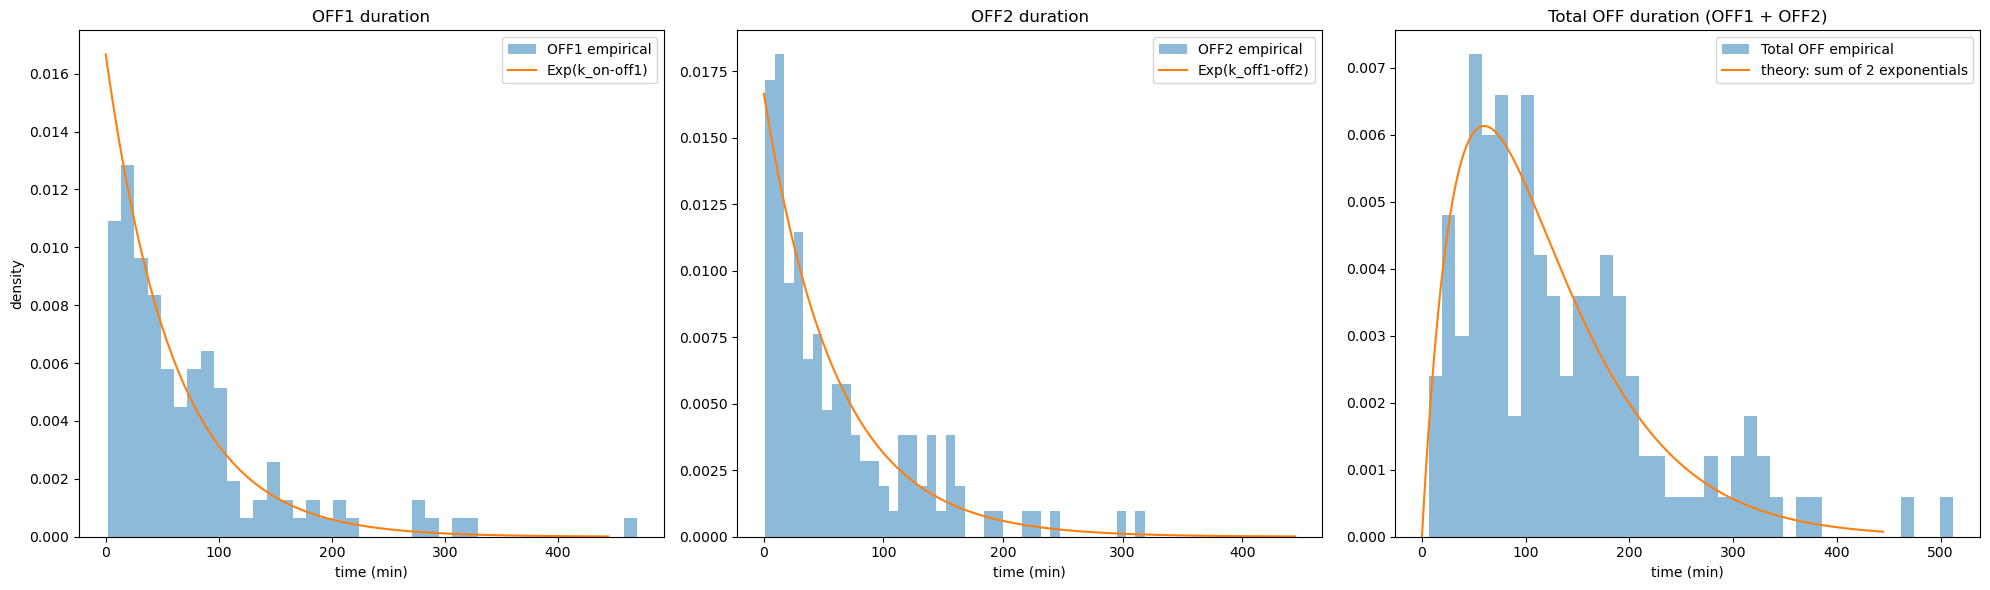

In [47]:
# Theory : OFF1 ~ Exp(koffoff), OFF2 ~ Exp(koffon),
# OFF_total = T2 + T3 (sum of 2 exponentials with different rates)
k1 = koffoff     # OFF1 -> OFF2
k2 = koffon       # OFF2 -> ON

t_max = np.percentile(off_total_durations, 99) 
t_grid = np.linspace(0, t_max, 300)

pdf_off1 = k1 * np.exp(-k1 * t_grid)
pdf_off2 = k2 * np.exp(-k2 * t_grid)
if abs(k1 - k2) < 1e-9: #avoid division by zero when k1 ~= k2
    pdf_off_total = (k1**2) * t_grid * np.exp(-k1 * t_grid)
else:
    pdf_off_total = (k1*k2/(k2-k1))*(np.exp(-k1*t_grid)-np.exp(-k2*t_grid))


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# OFF1
axes[0].hist(off1_durations, bins=40, density=True, alpha=0.5, label='OFF1 empirical')
axes[0].plot(t_grid, pdf_off1, label='Exp(k_on-off1)')
axes[0].set_title('OFF1 duration')
axes[0].set_xlabel('time (min)')
axes[0].set_ylabel('density')
axes[0].legend()

# OFF2
axes[1].hist(off2_durations, bins=40, density=True, alpha=0.5, label='OFF2 empirical')
axes[1].plot(t_grid, pdf_off2, label='Exp(k_off1-off2)')
axes[1].set_title('OFF2 duration')
axes[1].set_xlabel('time (min)')
axes[1].legend()

# OFF total
axes[2].hist(off_total_durations, bins=40, density=True, alpha=0.5, label='Total OFF empirical')
axes[2].plot(t_grid, pdf_off_total, label='theory: sum of 2 exponentials')
axes[2].set_title('Total OFF duration (OFF1 + OFF2)')
axes[2].set_xlabel('time (min)')
axes[2].legend()

plt.tight_layout()
plt.show()


$OFF_{1}$ and $OFF_{2}$ durations are expontial. We use the rates of exit : $k_{offoff}$ and $k_{offon}$ because the durarion spent in a $OFF$ state depends on the rate of leaving the state. The total $OFF$ time is the sum of the two $OFF$ exponentials. We just need to be careful of the division by 0 because we chose $k_{offoff} = k_{offon}$. Therefore, the total OFF duration follows an Erlang distribution of shape 2: 
$$
\lambda^{2}te^{-\lambda t}
$$
without the 0 division we could have chosen this distribution:
$$
\frac{k_{1}k_{2}}{k_{2}-k_{1}}\left(e^{-k_{1} t} - e^{-k_{2} t}\right),\quad t \ge 0.
$$
$\lambda^{2}te^{-\lambda t}$ (for total $OFF$ ) and exponantials for single $OFF$ durations are what we observe with the `gillespie_refractory` data: single $OFF$ durations decay exponentially, while total $OFF$ shows a peaked distribution rather than a purely exponential decay.

#### 3) $OFF_{n}$ states

If we consider now $OFF_{n}$ states:
Each $OFF$ state is left with a single rate $k_{n}$ with exponentional decay, we have: 
$$  
T_{OFF_n}\sim \mathrm{Exp}(\lambda_n),\text{where } \lambda_n \text{ is the exit rate of state } OFF_n.
$$  
When we had 2 $OFF$ states the total $OFF$ was the sum of the two exponentials. But if we add more $OFF$ states, this time the sum use the $n$ states, and we have:
$$
T = \sum_{i=1}^{n} T_{OFF_i},
$$
which follows a Gamma distribution with shape \(n\).  
As \(n\) (number of states) increases, the distribution becomes increasingly peaked and approaches a Gaussian (central limit theorem).  
Biologically, this corresponds to a stronger refractory period, where the promoter must pass through several biochemical steps before reactivating transcription.